In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import math
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
 
from funciones import read_data, calcular_distancia, calcular_matriz_dist, calcular_largo_ruta, graficar_ruta
from solvers_listos import generar_ruta, graficar_rutas 
# from instancia import ubis, cap_tpte, info_locales
# from instancia import G, color_nodos, color_arcos, ancho_edges
from instancia import crear_grafo_inicial

random.seed(1)
np.random.seed(1)

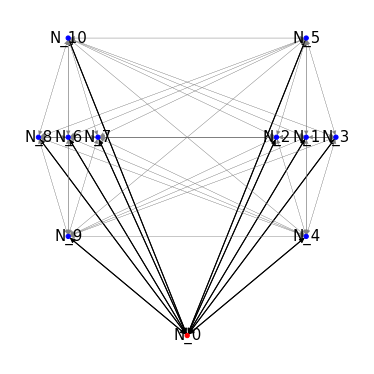

{'Inv': 34884, 'Up': 100000, 'Low': 0, 'Prod': 65116, 'h': 0.3, 'coord_x': 0, 'coord_y': 50, 'pos': (0, 50)}
{'Inv': 95, 'Up': 174, 'Low': 0, 'Prod': 79, 'h': 0.23, 'coord_x': 200, 'coord_y': 100, 'pos': (200, 100)}
{'Inv': 36, 'Up': 54, 'Low': 0, 'Prod': 18, 'h': 0.32, 'coord_x': 150, 'coord_y': 100, 'pos': (150, 100)}
{'Inv': 13, 'Up': 30, 'Low': 0, 'Prod': 17, 'h': 0.33, 'coord_x': 250, 'coord_y': 100, 'pos': (250, 100)}
{'Inv': 62, 'Up': 110, 'Low': 0, 'Prod': 48, 'h': 0.23, 'coord_x': 200, 'coord_y': 75, 'pos': (200, 75)}
{'Inv': 133, 'Up': 213, 'Low': 0, 'Prod': 80, 'h': 0.18, 'coord_x': 200, 'coord_y': 125, 'pos': (200, 125)}
{'Inv': 92, 'Up': 138, 'Low': 0, 'Prod': 46, 'h': 0.29, 'coord_x': -200, 'coord_y': 100, 'pos': (-200, 100)}
{'Inv': 108, 'Up': 237, 'Low': 0, 'Prod': 129, 'h': 0.42, 'coord_x': -150, 'coord_y': 100, 'pos': (-150, 100)}
{'Inv': 35, 'Up': 129, 'Low': 0, 'Prod': 94, 'h': 0.42, 'coord_x': -250, 'coord_y': 100, 'pos': (-250, 100)}
{'Inv': 108, 'Up': 154, 'Low':

In [380]:
G, ubis, cap_tpte, info_locales = crear_grafo_inicial(archivo= 'IRP2.xlsx', plot=True)

for nodo in G.nodes(data=True):
    si_o_no = random.randint(0,1)
    if True:
        up = nodo[1]['Up']
        new_d = random.randint(int(up*0.25), int(up*0.75))
        G.nodes[nodo[0]]['Prod'] = new_d
        G.nodes[nodo[0]]['Inv'] = up - new_d

    print(G.nodes(data=True)[nodo[0]])

In [381]:
def reaccion_inventario(G, mu, sd, alfa = 0.05):
    """
    Función que verifica que locales deben ser visitados en base a su inventario actual. 
    En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
    """
    visitas = {nodo : False for nodo in G.nodes()}
    for nodo in G.nodes(data=True):
        id_nodo = int(nodo[0][2:])-1
        media = mu[id_nodo]
        desviacion = sd[id_nodo]
        s = media + norm.ppf((1 - alfa)/2)* desviacion  #Stock de seguridad
        if nodo[1]['Inv'] <= s:
            visitas[nodo[0]] = True
    
    return visitas

In [382]:
def IC_nrm(mu, sd, M=1000, alfa = 0.95):
    """
    Función que calcula el intervalo de confianza para una distribución normal.
    """
    limite_inferior = mu + norm.ppf((1 - alfa) / 2) * sd / math.sqrt(M)
    limite_superior = mu - norm.ppf((1 - alfa) / 2) * sd / math.sqrt(M)
    
    return limite_inferior, limite_superior

In [383]:
def simular_demanda_previa(G, dist = 'n', T =100, ruido = 0):
    """
    Función que simula la demanda previa de los locales.
    """
    demandas = {nodo : [] for nodo in G.nodes() if nodo != 'N_0'}
    # r = {nodo : nodo[1]['Prod'] for nodo in G.nodes(data=True)}
    if dist == 'n':
        for nodo in G.nodes(data=True):
            # print(nodo[0],nodo[1]['Prod'])
            if nodo[0] != 'N_0':
                dem_pasadas = [max(
                    np.random.normal(loc = nodo[1]['Prod'], scale = nodo[1]['Prod'] * 0.05) 
                    + np.random.normal(loc = 0, scale = nodo[1]['Prod'] * ruido)
                    ,0) for _ in range(T)]
                demandas[nodo[0]] = dem_pasadas
         
    return demandas

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#ejemplo demanda historica

muestra = False

if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000, ruido=0.05) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in dem_historico.keys()}
    print(demanda)
    print(dem_historico.keys())
    plt.figure(figsize=(10, 5))
    plt.plot(demanda.values(), 'o', color='black') 
    # for nodo in dem_historico.keys():
    #     if nodo != 'N_0':
    #         # plt.plot(dem_historico[nodo])
    #         plt.plot(smooth(dem_historico[nodo], 10))
    plt.xlabel('Días')
    plt.ylabel('Demanda')
    plt.xticks(np.arange(len(demanda)), demanda.keys())
    plt.title('Demanda histórica')
    plt.show()


In [384]:
def SEDA(datos, historia = False, alpha=0.1, beta=0.1, theta=0.5):
    '''
    Suavizamiento Exponencial Doble Amortiguado
    Aplica el método de suavizamiento exponencial doble a una serie de datos,
    específicmamente el Método de Holt Damped.
    '''
    I = [datos[0]]
    S = [datos[1]-datos[0]]
    for i in range(1,len(datos)):
        I.append(alpha*datos[i] + (1-alpha)*(I[i-1]+ theta*S[i-1]))
        S.append(beta*(I[i]-I[i-1])+(1-beta)*S[i-1])
    
    y = I[-1] + theta * S[-1]
    if historia == False:
        return y
    elif historia == True:
        I.append(y)
        return I
    elif historia == 'S':
        return I, S
    
def pronostico_SEDA(datos, T, pron = False, alpha=0.1, beta=0.1, theta=0.5):
    '''
    Devuelve un pronóstico para los siguientes T periodos mediante Suavizamiento Exponencial Doble Amortiguado
    '''
    I,S = SEDA(datos, historia = 'S', alpha=alpha, beta=beta, theta=theta)
    pronostico = []
    for i in range(T):
        y = I[-1] + theta * S[-1]
        pronostico.append(y)
        I.append(alpha*y + (1-alpha)*(I[-1]+ theta*S[-1]))
        S.append(beta*(I[-1]-I[-2]) + (1-beta)*S[-1])
    
    return pronostico

muestra = False

if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000, ruido = 0.05) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in dem_historico.keys()}
    data = {nodo: dem_historico[nodo][1:] for nodo in dem_historico.keys()}
    y = [SEDA(data[nodo], historia=False, alpha = 0.5) for nodo in data.keys()]
    medias = [np.mean(data[nodo]) for nodo in data.keys()]
    ind = np.arange(len(y))

    # y = [SEDA(dem_historico[nodo], pron=True, alpha = 0.5) for nodo in set(dem_historico)-set(['N_0'])]
    # medias = [np.mean(dem_historico[nodo]) for nodo in set(dem_historico)-set(['N_0'])]
    # ind = np.arange(len(y))
    
    # print(y)
    ancho = 0.3
    plt.figure(figsize=(10, 5))
    plt.plot(y, 'o', label='Pronóstico', color='red')
    plt.plot(medias, 'o', label='Promedio', color='blue')
    plt.plot(demanda.values(), 'o', label='Realización', color='black')
    # plt.bar(ind, y, width=ancho, label='Pronóstico', color='red')
    # plt.bar(ind + ancho, medias, width=ancho, label='Promedio', color='blue')
    plt.xticks(ind + ancho / 2, [f'N_{i}' for i in range(1,len(y)+1)])

    plt.xlabel('Local')
    plt.ylabel('Demanda')
    plt.title('Demanda: Pronóstico y realización para t+1')
    plt.legend()
    plt.show()

In [385]:
for nodo in G.nodes(data=True):
    print(nodo[0],nodo[1]['Inv'])

N_0 34884
N_1 95
N_2 36
N_3 13
N_4 62
N_5 133
N_6 92
N_7 108
N_8 35
N_9 108
N_10 132


In [386]:
def ejecutar_ruta(G,ruta,matriz_dst):
    """
    Función que simula la ejecución de una ruta.
    """
    ruta = ruta.copy()
    ruta.pop(0)
    ruta.pop(-1)
    ruta = [int(nodo[2:]) for nodo in ruta]
    # distancia = calcular_largo_ruta(ruta, matriz_dst)
    stock = 0
    for nodo in ruta:
        stock += G.nodes[f'N_{nodo}']['Up'] - G.nodes[f'N_{nodo}']['Inv']
        G.nodes[f'N_{nodo}']['Inv'] = G.nodes[f'N_{nodo}']['Up']
    G.nodes['N_0']['Inv'] -= stock
    return G, stock

def realizacion_demanda(G, ruido = 0.05):
    """
    Función que simula la demanda de los locales para un determinado periodo.
    """
    grafo = G.copy()
    demandas = {nodo : [] for nodo in G.nodes() if nodo != 'N_0'}
    insatisfecho = 0
    for nodo in grafo.nodes(data=True):
        if nodo[0] != 'N_0':
            dem = max(
                np.random.normal(loc = nodo[1]['Prod'], scale = nodo[1]['Prod'] * 0.05) 
                + np.random.normal(loc = 0, scale = nodo[1]['Prod'] * 0.05)
                ,0)
            demandas[nodo[0]] = dem
            if dem <= grafo.nodes[nodo[0]]['Inv']:
                grafo.nodes[nodo[0]]['Inv'] -= dem
            else:
                grafo.nodes[nodo[0]]['Inv'] = 0
                insatisfecho += dem - grafo.nodes[nodo[0]]['Inv']

    return grafo, demandas, insatisfecho
Gprima, d, ins = realizacion_demanda(G)

for nodo in Gprima.nodes(data=True):
    print(nodo[0],nodo[1]['Inv'])

N_0 34884
N_1 15.522420522190501
N_2 17.940113756209506
N_3 0
N_4 11.947976334952557
N_5 53.21833160372813
N_6 51.74182908906556
N_7 0
N_8 0
N_9 61.29385828354976
N_10 80.72170868499701


In [387]:
dem_historico_test = simular_demanda_previa(G, dist = 'n', T=1000) 
mu_d = [np.mean(dem_historico_test[nodo]) for nodo in dem_historico_test.keys()]    
sd_d = [np.std(dem_historico_test[nodo]) for nodo in dem_historico_test.keys()]
vis = reaccion_inventario(G, mu_d, sd_d)
np.sum(mu_d)

613.7118700505612

In [388]:
def simular_ejecucion_R(grafo_inicial = G, T=1):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : [] for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    perdido = 0
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        mu_demanda = [np.mean(dem_historico[nodo]) for nodo in dem_historico.keys()]    
        sd_demanda = [np.std(dem_historico[nodo]) for nodo in dem_historico.keys()]
        # pronostico = [pronostico_SEDA(dem_historico[nodo], T = 10, pron = True, alpha=0.1, beta=0.1, theta=0.5) for nodo in dem_historico.keys()]

        # Estrategia Reactiva (R)  
        visitas_reaccion = reaccion_inventario(G0, mu_demanda, sd_demanda)
        # print("Visitas reacción: ", visitas_reaccion)
        
        if sum(visitas_reaccion.values()) == 0:
            print("No hay locales que visitar")
            rutas[t] = []

        else:    
            ruta_R, largo_ruta_R = generar_ruta(G0, matriz_dst, visitas_reaccion) #devuelve la ruta a realizar
            rutas[t] = ruta_R
            print(f"Ruta {t}: ", ruta_R )
            G0, stock = ejecutar_ruta(G0, ruta_R, matriz_dst)
            
        G0, demanda, insatisfecho = realizacion_demanda(G0)
        perdido += insatisfecho

        inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones]

        costo = sum([h[i]*inventarios[i] for i in range(len(inventarios))])
        
        for nodo in ubicaciones:
            if nodo != 'N_0':
                dem_historico[nodo].append(demanda[nodo])
    print('\n')
    print("Inventario final: ")
    for nodo in G0.nodes(data=True):
        print(nodo[0],nodo[1]['Inv'])
    print(f'Demanda perdida total: {perdido} | Demanda perdida promedio: {perdido/T}')
    
    return rutas, dem_historico
        
        
mis_rutas, dem_historico = simular_ejecucion_R(grafo_inicial = G, T = 365)
        

Inventario inicial: 
N_0 34884
N_1 95
N_2 36
N_3 13
N_4 62
N_5 133
N_6 92
N_7 108
N_8 35
N_9 108
N_10 132


Ruta 0:  ['N_0', 'N_8', 'N_7', 'N_3', 'N_0']
Ruta 1:  ['N_0', 'N_2', 'N_1', 'N_4', 'N_3', 'N_5', 'N_7', 'N_8', 'N_0']
Ruta 2:  ['N_0', 'N_7', 'N_6', 'N_9', 'N_8', 'N_10', 'N_3', 'N_0']
Ruta 3:  ['N_0', 'N_4', 'N_1', 'N_3', 'N_5', 'N_2', 'N_7', 'N_8', 'N_0']
Ruta 4:  ['N_0', 'N_8', 'N_7', 'N_3', 'N_0']
Ruta 5:  ['N_0', 'N_7', 'N_6', 'N_9', 'N_8', 'N_10', 'N_5', 'N_1', 'N_4', 'N_3', 'N_0']
Ruta 6:  ['N_0', 'N_3', 'N_2', 'N_7', 'N_8', 'N_0']


Ruta 7:  ['N_0', 'N_8', 'N_7', 'N_4', 'N_1', 'N_5', 'N_3', 'N_0']
Ruta 8:  ['N_0', 'N_3', 'N_2', 'N_7', 'N_9', 'N_6', 'N_10', 'N_8', 'N_0']
Ruta 9:  ['N_0', 'N_8', 'N_7', 'N_4', 'N_1', 'N_5', 'N_3', 'N_0']
Ruta 10:  ['N_0', 'N_3', 'N_2', 'N_7', 'N_6', 'N_8', 'N_0']
Ruta 11:  ['N_0', 'N_7', 'N_9', 'N_8', 'N_10', 'N_5', 'N_1', 'N_4', 'N_3', 'N_0']
Ruta 12:  ['N_0', 'N_8', 'N_6', 'N_7', 'N_3', 'N_0']
Ruta 13:  ['N_0', 'N_4', 'N_1', 'N_3', 'N_5', 'N_2', 'N_7', 'N_8', 'N_0']
Ruta 14:  ['N_0', 'N_7', 'N_6', 'N_9', 'N_8', 'N_10', 'N_3', 'N_0']
Ruta 15:  ['N_0', 'N_4', 'N_1', 'N_3', 'N_5', 'N_2', 'N_7', 'N_8', 'N_0']
Ruta 16:  ['N_0', 'N_8', 'N_7', 'N_3', 'N_0']
Ruta 17:  ['N_0', 'N_4', 'N_3', 'N_5', 'N_1', 'N_2', 'N_7', 'N_9', 'N_6', 'N_10', 'N_8', 'N_0']
Ruta 18:  ['N_0', 'N_8', 'N_7', 'N_3', 'N_0']
Ruta 19:  ['N_0', 'N_8', 'N_7', 'N_5', 'N_1', 'N_4', 'N_3', 'N_0']
Ruta 20:  ['N_0', 'N_3', 'N_2', 'N_7', 'N_9', 'N_6', 'N_10', 'N_8', 'N_0']
Ruta 21:  ['N_0', 'N_8', 'N_7', 'N_4', 'N_1', 'N_5', 

## Procesamiento de Resultados

In [390]:
N = len(G.nodes())-1
def generar_df(rutas, N):

    rutas_bool = dict()
    for ruta, nodos in rutas.items():
        bools = dict()
        for i in range(1, N+1):
            if f'N_{i}' in nodos:
                bools[f'N_{i}'] = 1
            else:
                bools[f'N_{i}'] = 0
        rutas_bool[ruta] = bools
    
    df = pd.DataFrame.from_dict(rutas_bool, orient='index')
    
    df.rename(columns={'index': 'Ruta', 0: 'Nodo'}, inplace=True)
    df.rename_axis('Ruta', inplace=True)
    return df

df = generar_df(mis_rutas, N)
df['sum'] = df.sum(axis=1)


In [391]:
df_nodos = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
df_nodos = df_nodos.iloc[1:]
df_nodos['frec'] = (df.describe()).T['mean']
dem_historico_media = {nodo: np.mean(dem_historico[nodo]) for nodo in dem_historico.keys()}
df_nodos['dem_mean'] = dem_historico_media.values()
df_nodos

,Inv,Up,Low,Prod,h,coord_x,coord_y,pos,frec,dem_mean
N_1,95,174,0,79,0.23,200,100,"(200, 100)",0.501370,78.797523
N_2,36,54,0,18,0.32,150,100,"(150, 100)",0.391781,17.993419
N_3,13,30,0,17,0.33,250,100,"(250, 100)",1.000000,16.991937
N_4,62,110,0,48,0.23,200,75,"(200, 75)",0.498630,48.089211
N_5,133,213,0,80,0.18,200,125,"(200, 125)",0.498630,80.000615
N_6,92,138,0,46,0.29,-200,100,"(-200, 100)",0.397260,45.945083
N_7,108,237,0,129,0.42,-150,100,"(-150, 100)",0.991781,129.320507
N_8,35,129,0,94,0.42,-250,100,"(-250, 100)",1.000000,94.174434
N_9,108,154,0,46,0.24,-200,75,"(-200, 75)",0.331507,46.125482
N_10,132,189,0,57,0.43,-200,125,"(-200, 125)",0.331507,56.968984


In [392]:
indices_mayores = df_nodos[df_nodos['frec'] > 0.75].index
indices_medios = df_nodos[(df_nodos['frec'] > 0.45) & (df_nodos['frec'] <= 0.75)].index
indices_menores = df_nodos[df_nodos['frec'] <= 0.45].index

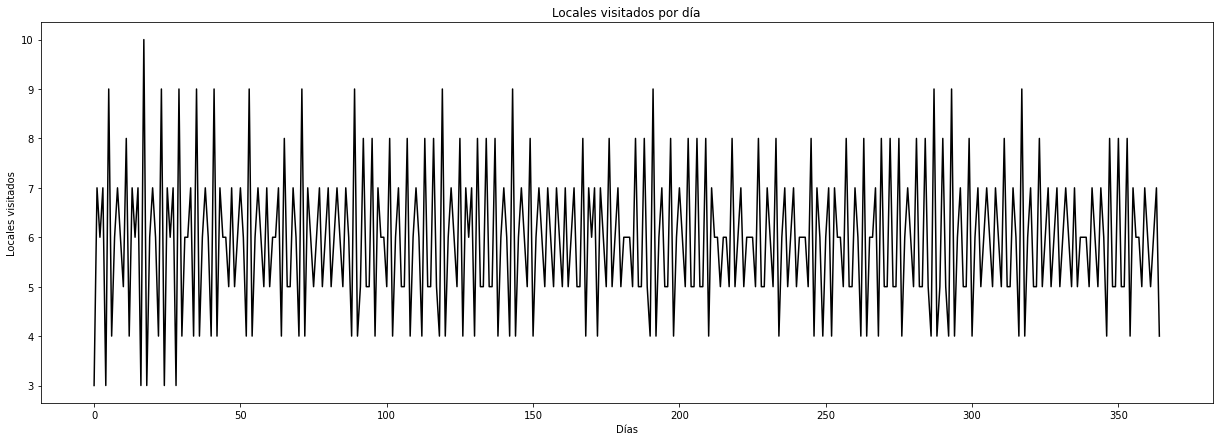

In [393]:
# graficaremos una serie de tiempo para el total de locales en cada día
# para esto, debemos sumar la cantidad de locales visitados en cada día, ya lo hicimos en la última columna

plt.figure(figsize=(21, 7))
plt.plot(df['sum'], '-', color='black')
plt.xlabel('Días')
plt.ylabel('Locales visitados')
plt.title('Locales visitados por día')
plt.show()

In [394]:
"""
# replicamos algo así pero ahora para cada local en vez de la suma, lo haremos sobre el mismo gráfico
# lo haremos solo con los primeros 150 días
plt.figure(figsize=(30, 7))
for i in range(1, N+1):
    plt.plot(df[f'N_{i}'][:150], '-', label=f'N_{i}')
plt.xlabel('Días')
plt.ylabel('Locales visitados')
plt.title('Locales visitados por día')
plt.legend()
plt.show()
"""

"\n# replicamos algo así pero ahora para cada local en vez de la suma, lo haremos sobre el mismo gráfico\n# lo haremos solo con los primeros 150 días\nplt.figure(figsize=(30, 7))\nfor i in range(1, N+1):\n    plt.plot(df[f'N_{i}'][:150], '-', label=f'N_{i}')\nplt.xlabel('Días')\nplt.ylabel('Locales visitados')\nplt.title('Locales visitados por día')\nplt.legend()\nplt.show()\n"

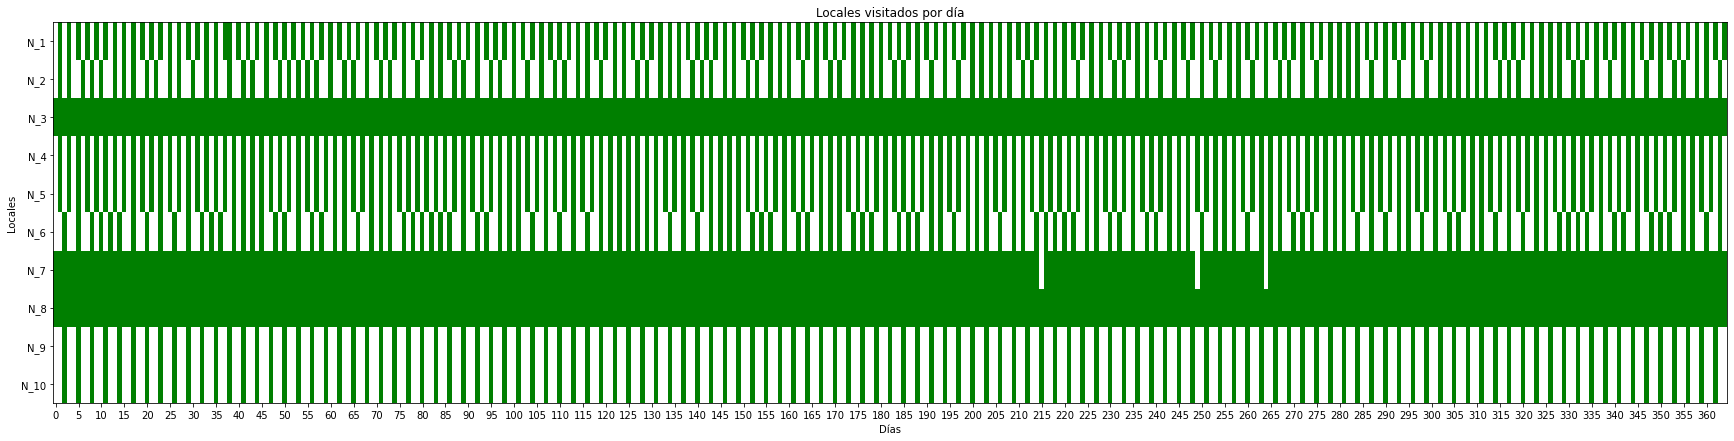

In [395]:

from matplotlib.colors import ListedColormap


# Define colormap

cmap = ListedColormap(['w', 'g'], N=2)

# Plot matrix

fig, ax = plt.subplots(figsize=(30, 7))
if 'sum' in df.columns:
    df.drop('sum', axis=1, inplace=True)
ax.imshow(df.T, cmap=cmap, vmin=0, vmax=1, aspect='auto')
ax.set_title('Locales visitados por día')
ax.set_xlabel('Días')
ax.set_ylabel('Locales')
ax.set_yticks(np.arange(N))
ax.set_yticklabels([f'N_{i}' for i in range(1, N+1)])
ax.set_xticks(np.arange(0, len(df), 5))

# modificamos el tamaño de la figura

plt.show()

In [396]:
df_nodos

,Inv,Up,Low,Prod,h,coord_x,coord_y,pos,frec,dem_mean
N_1,95,174,0,79,0.23,200,100,"(200, 100)",0.501370,78.797523
N_2,36,54,0,18,0.32,150,100,"(150, 100)",0.391781,17.993419
N_3,13,30,0,17,0.33,250,100,"(250, 100)",1.000000,16.991937
N_4,62,110,0,48,0.23,200,75,"(200, 75)",0.498630,48.089211
N_5,133,213,0,80,0.18,200,125,"(200, 125)",0.498630,80.000615
N_6,92,138,0,46,0.29,-200,100,"(-200, 100)",0.397260,45.945083
N_7,108,237,0,129,0.42,-150,100,"(-150, 100)",0.991781,129.320507
N_8,35,129,0,94,0.42,-250,100,"(-250, 100)",1.000000,94.174434
N_9,108,154,0,46,0.24,-200,75,"(-200, 75)",0.331507,46.125482
N_10,132,189,0,57,0.43,-200,125,"(-200, 125)",0.331507,56.968984


In [397]:
cantidad_06 = len(df_nodos[df_nodos['frec'] >= 0.5])
cantidad_04 = len(df_nodos[df_nodos['frec'] < 0.5])

print (f'Locales visitados más de 50% de los días: {cantidad_06}, que corresponde a un {cantidad_06/N*100}%')
print (f'Locales visitados menos de 50% de los días: {cantidad_04}, que corresponde a un {cantidad_04/N*100}%')

Locales visitados más de 50% de los días: 4, que corresponde a un 40.0%
Locales visitados menos de 50% de los días: 6, que corresponde a un 60.0%


In [398]:
def dispersion_intervalos(df):
    '''
    Función que calcula la cantidad promedio de días entre visitas a cada local.
    También entrega la desviación estándar de los intervalos.
    '''
    df = df.copy()
    if 'sum' in df.columns:
        df.drop('sum', axis=1, inplace=True)
    datos = {nodo: {'mean': None, 'std': None} for nodo in df.columns}
    for nodo in df.columns:
        largos = []
        ultima_visita = 0
        for dia in range(len(df)):
            if df[nodo][dia] == 1:
                if dia - ultima_visita > 3:
                    #print(f'El local {nodo} no fue visitado por {dia - ultima_visita} días')
                    pass
                largos.append(dia - ultima_visita)
                ultima_visita = dia
        datos[nodo]['mean'] = np.mean(largos)
        datos[nodo]['std'] = np.std(largos)
    datos_df = pd.DataFrame.from_dict(datos, orient='index')
    return datos_df

datos = dispersion_intervalos(df)
        

df_nodos['mean'] = datos['mean']
df_nodos['std'] = datos['std']
df_nodos['porcentaje demanda'] = df_nodos['dem_mean'] / df_nodos['Up']
df_nodos['porcentaje dem. inicial'] = df_nodos['Prod'] / df_nodos['Up']
df_nodos_corr = df_nodos[['Inv','Up','Low','Prod','h','frec','mean','std','dem_mean','porcentaje demanda','porcentaje dem. inicial']]


In [399]:
df_nodos

,Inv,Up,Low,Prod,h,coord_x,coord_y,pos,frec,dem_mean,mean,std,porcentaje demanda,porcentaje dem. inicial
N_1,95,174,0,79,0.23,200,100,"(200, 100)",0.501370,78.797523,1.989071,0.103969,0.452859,0.454023
N_2,36,54,0,18,0.32,150,100,"(150, 100)",0.391781,17.993419,2.538462,0.512354,0.333211,0.333333
N_3,13,30,0,17,0.33,250,100,"(250, 100)",1.000000,16.991937,0.997260,0.052271,0.566398,0.566667
N_4,62,110,0,48,0.23,200,75,"(200, 75)",0.498630,48.089211,1.994505,0.073921,0.437175,0.436364
N_5,133,213,0,80,0.18,200,125,"(200, 125)",0.498630,80.000615,1.994505,0.073921,0.375590,0.375587
N_6,92,138,0,46,0.29,-200,100,"(-200, 100)",0.397260,45.945083,2.503448,0.499988,0.332935,0.333333
N_7,108,237,0,129,0.42,-150,100,"(-150, 100)",0.991781,129.320507,1.005525,0.104972,0.545656,0.544304
N_8,35,129,0,94,0.42,-250,100,"(-250, 100)",1.000000,94.174434,0.997260,0.052271,0.730034,0.728682
N_9,108,154,0,46,0.24,-200,75,"(-200, 75)",0.331507,46.125482,2.991736,0.090533,0.299516,0.298701
N_10,132,189,0,57,0.43,-200,125,"(-200, 125)",0.331507,56.968984,2.991736,0.090533,0.301423,0.301587


In [400]:
df_nodos_corr.corr()

,Inv,Up,Low,Prod,h,frec,mean,std,dem_mean,porcentaje demanda,porcentaje dem. inicial
Inv,1.000000,0.882280,NaN,0.449910,-0.180263,-0.491455,0.487872,-0.150654,0.448832,-0.548876,-0.549805
Up,0.882280,1.000000,NaN,0.817338,0.029009,-0.098037,0.085093,-0.312755,0.816640,-0.124131,-0.125541
Low,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Prod,0.449910,0.817338,NaN,1.000000,0.275674,0.415533,-0.435706,-0.408972,0.999994,0.436309,0.434771
h,-0.180263,0.029009,NaN,0.275674,1.000000,0.484188,-0.301759,-0.028448,0.276945,0.417702,0.416561
frec,-0.491455,-0.098037,NaN,0.415533,0.484188,1.000000,-0.964054,-0.408833,0.416834,0.922117,0.921852
mean,0.487872,0.085093,NaN,-0.435706,-0.301759,-0.964054,1.000000,0.389692,-0.436530,-0.921144,-0.921417
std,-0.150654,-0.312755,NaN,-0.408972,-0.028448,-0.408833,0.389692,1.000000,-0.409222,-0.438992,-0.438213
dem_mean,0.448832,0.816640,NaN,0.999994,0.276945,0.416834,-0.436530,-0.409222,1.000000,0.437113,0.435560
porcentaje demanda,-0.548876,-0.124131,NaN,0.436309,0.417702,0.922117,-0.921144,-0.438992,0.437113,1.000000,0.999986


In [401]:
def proactiva_inventario(G, pronostico):
    """
    Función que verifica que locales deben ser visitados en base a su inventario. 
    En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
    """
    visitas = {nodo : False for nodo in G.nodes()}
    for nodo in G.nodes(data=True):
        id_nodo = int(nodo[0][2:])-1
        media = mu[id_nodo]
        desviacion = sd[id_nodo]
        s = media + norm.ppf((1 - alfa)/2)* desviacion  #Stock de seguridad
        if nodo[1]['Inv'] <= s:
            visitas[nodo[0]] = True
            
    for nodo in G.nodes(data=True):
        mean = nodo[1]['Prod'] + mu
        sd = nodo[1]['Prod'] * sigma
        l_inf, l_sup = IC_nrm(mean, sd, alfa = 0.95)
        pronostico = l_sup
        if nodo[1]['Inv'] - pronostico <= tolerancia * nodo[1]['Up']:
            visitas[nodo[0]] = True
    
    return visitas

In [402]:
def simular_ejecucion_P(grafo_inicial = G, T=1):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : [] for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        pronostico = [pronostico_SEDA(dem_historico[nodo], T = 10, pron = True, alpha=0.2, beta=0.1, theta=0.5) for nodo in dem_historico.keys()]
        # for i in range(len(pronostico)):
        #       print(f"Pronóstico: N_{i+1}, {pronostico[i]}") 
         
        visitas_proactiva = proactiva_inventario(G0, tolerancia = 0.2, dist = 'n', mu = 0, sigma = 0.1, M = 1000)

        print("Visitas reacción: ", visitas_proactiva)
        
        ruta_R, largo_ruta = generar_ruta(G0, matriz_dst, visitas_proactiva) #devuelve la ruta a realizar

        G0 = ejecutar_ruta(G0, ruta_R, matriz_dst)
        G0, demanda, insatisfecho = realizacion_demanda(G0)

        # Estrategia Proactiva (P)
        
        
        
simular_ejecucion_P(grafo_inicial = G, T = 1)

Inventario inicial: 
N_0 34884
N_1 95
N_2 36
N_3 13
N_4 62
N_5 133
N_6 92
N_7 108
N_8 35
N_9 108
N_10 132




TypeError: proactiva_inventario() got an unexpected keyword argument 'tolerancia'

In [ ]:
G.nodes(data=True)['N_0']['Inv']